In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
import warnings
warnings.filterwarnings("ignore")

In [117]:
import keras
import tensorflow

from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM, Embedding

In [2]:
train_df = pd.read_csv('../../../CMAPSSData/train_FD001.txt', sep = ' ', header = None)
test_df = pd.read_csv('../../../CMAPSSData/test_FD001.txt', sep = ' ', header = None)
rul_true=pd.read_csv('../../../CMAPSSData/RUL_FD001.txt', sep=',', header = None)


# 1. Veriyi Analiz Etme

## 1.1 Kolon adlarını ayarlama (train/ test veri seti için)

In [3]:
train_df.columns

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27],
           dtype='int64')

In [4]:
nonsensor_cols=['id', 'cycle', 'settings_1', 'settings_2', 'settings_3']
sensor_cols=['sensor_'+str(i) for i in range(1,24)]
nonsensor_cols.extend(sensor_cols)

In [5]:
train_df.columns = nonsensor_cols
test_df.columns = nonsensor_cols

In [6]:
train_df

,id,cycle,settings_1,settings_2,settings_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,NaN,NaN
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,NaN,NaN
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,NaN,NaN
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,NaN,NaN


In [7]:
test_df

,id,cycle,settings_1,settings_2,settings_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,NaN,NaN
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,NaN,NaN
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,NaN,NaN
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,NaN,NaN
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,NaN,NaN
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,NaN,NaN
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,NaN,NaN
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,NaN,NaN


## 1.2 Veri seti içeriğinin plotlanması

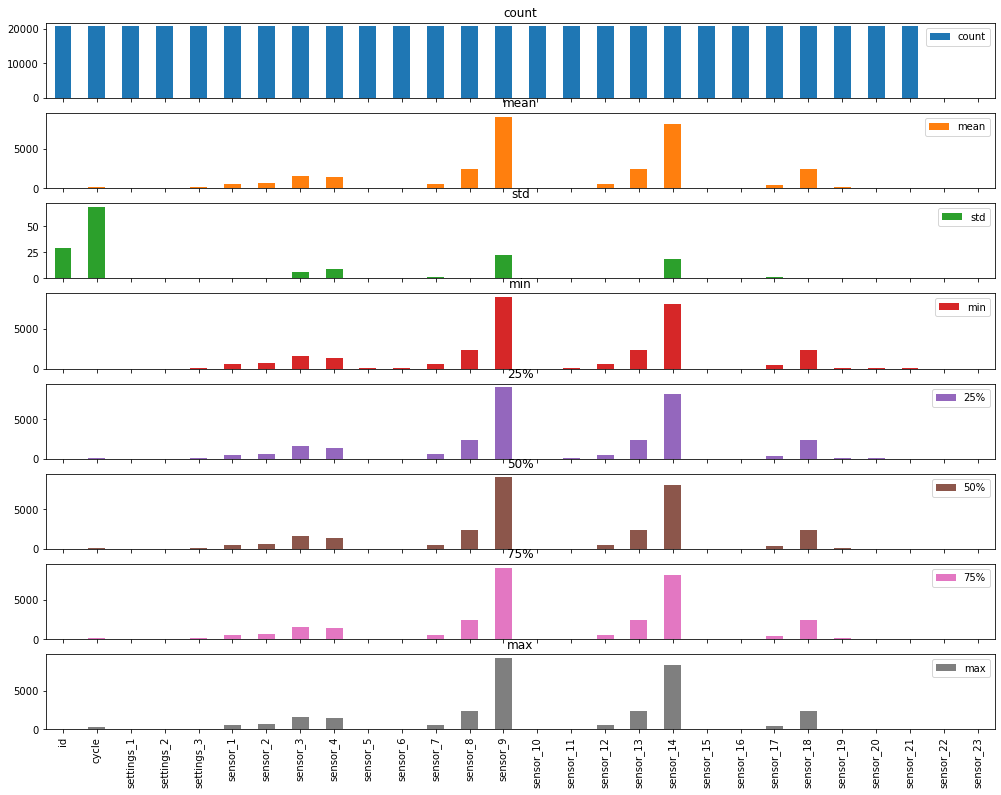

In [8]:
axes = train_df.describe().T.plot.bar(subplots = True, figsize = (17, 13))

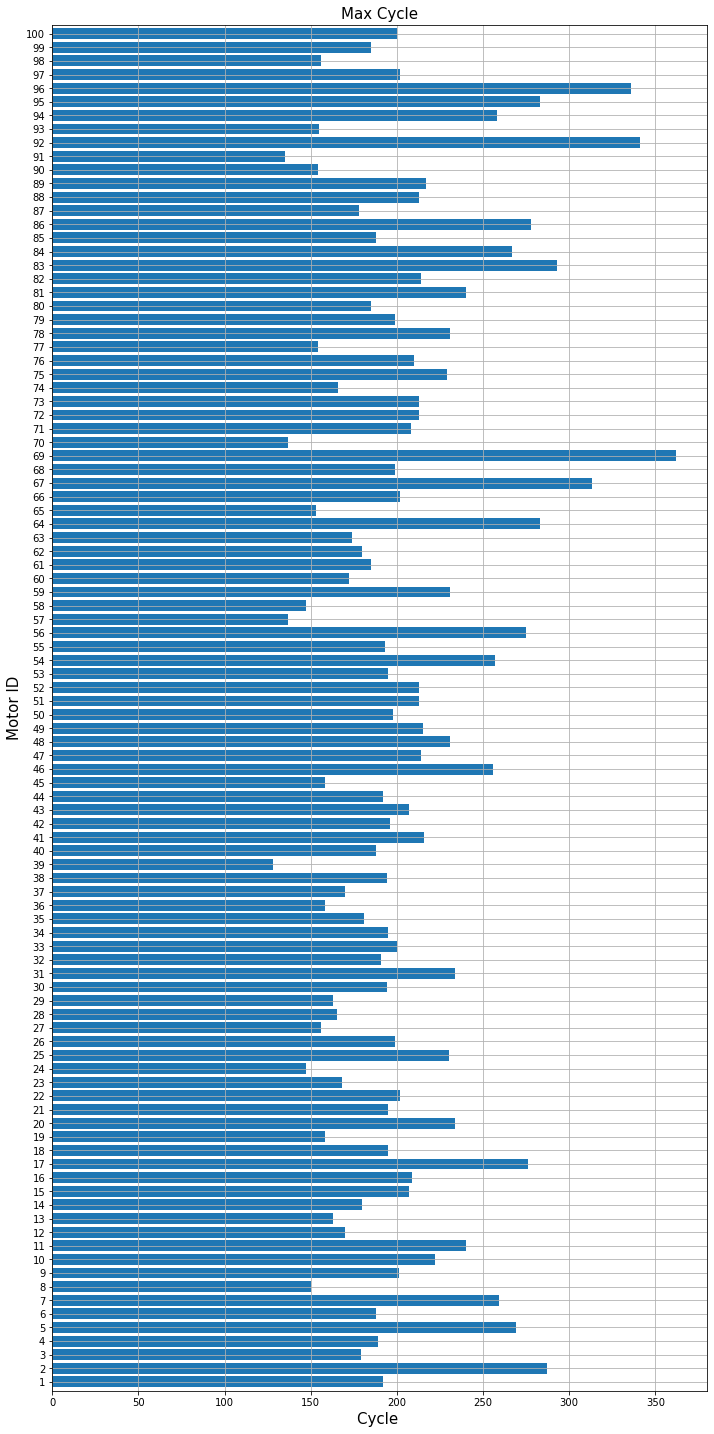

In [9]:
plt.figure(figsize=(10,20))
ax=train_df.groupby('id')['cycle'].max().plot(kind='barh',width=0.8, stacked=True,align='center',rot=0)
plt.title('Max Cycle',size=15)
plt.xlabel('Cycle ',size=15)
plt.xticks(size=10)
plt.ylabel('Motor ID',size=15)
plt.yticks(size=10)
plt.grid(True)
plt.tight_layout(True)
plt.show()

##  Veri setleri olarak elimizde 3 tane veri seti vardır.
### Bunlar:
- Train :Uçak motorunun arızaya kadar çalıştığı verilerdir.
- Test: Kaydedilen arıza olayları olmadan uçak motorunun çalışma verileridir.
- RUL_true : Test verilerinde her motor için gerçek kalan çevrim (cycle) bilgilerini içerir.

## 1.3 Train veri seti için RUL sütununu oluşturma 

In [10]:
max_cycle = train_df.groupby(['id'], sort = False)['cycle'].max().reset_index()
max_cycle = max_cycle.rename(columns ={"cycle":"max_cycle"})
max_cycle

,id,max_cycle
0,1,192
1,2,287
2,3,179
3,4,189
4,5,269
...,...,...
95,96,336
96,97,202
97,98,156
98,99,185


In [11]:
train_df = pd.merge(train_df, max_cycle, how = 'inner', on = 'id')
train_df

,id,cycle,settings_1,settings_2,settings_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,max_cycle
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN,192
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN,192
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN,192
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN,192
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN,192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,8.4956,0.03,397,2388,100.0,38.49,22.9735,NaN,NaN,200
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,8.5139,0.03,395,2388,100.0,38.30,23.1594,NaN,NaN,200
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,8.5646,0.03,398,2388,100.0,38.44,22.9333,NaN,NaN,200
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,8.5389,0.03,395,2388,100.0,38.29,23.0640,NaN,NaN,200


In [12]:
train_df['rul'] = train_df['max_cycle'] - train_df['cycle']
train_df.drop('max_cycle', axis = 1, inplace = True)
train_df

,id,cycle,settings_1,settings_2,settings_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,rul
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,8.4956,0.03,397,2388,100.0,38.49,22.9735,NaN,NaN,4
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,8.5139,0.03,395,2388,100.0,38.30,23.1594,NaN,NaN,3
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,8.5646,0.03,398,2388,100.0,38.44,22.9333,NaN,NaN,2
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,8.5389,0.03,395,2388,100.0,38.29,23.0640,NaN,NaN,1


In [13]:
test_df

,id,cycle,settings_1,settings_2,settings_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,NaN,NaN
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,NaN,NaN
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,NaN,NaN
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,NaN,NaN
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,NaN,NaN
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,NaN,NaN
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,NaN,NaN
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,NaN,NaN


## 1.4 Test veri seti için RUL sütununu oluşturma 

In [14]:
# test dataseti icin label sutunlarinin olusturulmasi (rul_true dataseti kullanilarak)

# Test: Kaydedilen arıza olayları olmadan uçak motorunun çalışma verileridir.
# RUL_true : Test verilerinde her motor için arızadan önceki kalan çevrim (cycle) bilgilerini içerir.

# Bunun için test veri setindeki çektiği cycle sayısı + arızadan önce kalan cycle saysı: 
# test_df['RUL']+RUL_TRUE['RUL']
# Eşittir toplam cycle sayısı -> rul_true['max'].

rul=pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns=['id','max']
rul_true.columns=['more']
rul_true['id']=rul_true.index+1
rul_true['max']=rul['max']+rul_true['more']
rul_true.drop('more', axis=1, inplace=True)
rul_true

,id,max
0,1,143
1,2,147
2,3,195
3,4,188
4,5,189
...,...,...
95,96,234
96,97,216
97,98,180
98,99,214


In [15]:
# Her bir mototrun toplam cycle sayısı belirlendikten sonra, 
# her çektiği cycle ile azalarak gerçek kalan cycle sayısına ulaşacaktır. 
# Bunun için 'motorun toplam cycle sayısı'-'motorun arızadan önceki çektiği cycle sayısı'
# Eşittir = 'gerçek kalan cycle sayısı'.

test_df=test_df.merge(rul_true, on=['id'], how='left')
test_df['rul']=test_df['max']-test_df['cycle']
test_df.drop('max', axis=1, inplace=True)
test_df

,id,cycle,settings_1,settings_2,settings_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,rul
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8.4052,0.03,392,2388,100.0,38.86,23.3735,NaN,NaN,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8.3803,0.03,393,2388,100.0,39.02,23.3916,NaN,NaN,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8.4441,0.03,393,2388,100.0,39.08,23.4166,NaN,NaN,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8.3917,0.03,391,2388,100.0,39.00,23.3737,NaN,NaN,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8.4031,0.03,390,2388,100.0,38.99,23.4130,NaN,NaN,138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,8.4715,0.03,394,2388,100.0,38.65,23.1974,NaN,NaN,24
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,8.4512,0.03,395,2388,100.0,38.57,23.2771,NaN,NaN,23
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,8.4569,0.03,395,2388,100.0,38.62,23.2051,NaN,NaN,22
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,8.4711,0.03,395,2388,100.0,38.66,23.2699,NaN,NaN,21


In [16]:
train_labeled = train_df.copy()

In [17]:
np.array(train_df.isnull().sum())

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0, 20631,
       20631,     0], dtype=int64)

In [18]:
np.array(test_df.isnull().sum())

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0, 13096,
       13096,     0], dtype=int64)

## 1.5 Kolonlar arası korelasyonların incelenmesi 

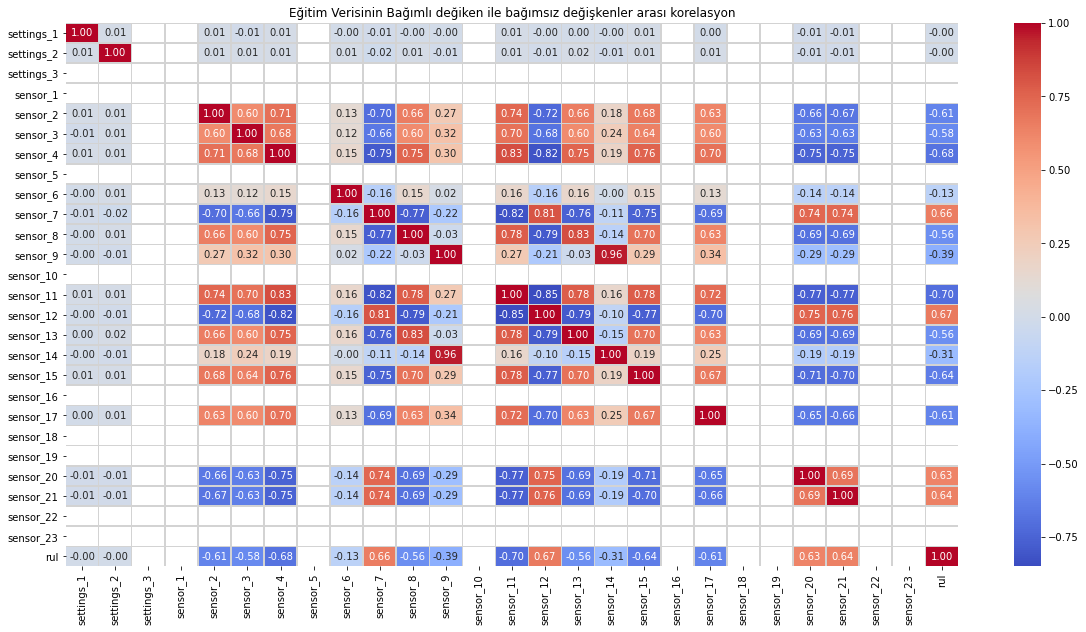

In [19]:
del train_df['id']

train_df.set_index('cycle', inplace = True)

df_corr = train_df.corr(method = 'pearson')
fig, axes = plt.subplots(figsize = (20, 10))
ax = sns.heatmap(round(df_corr,2), cmap="coolwarm", fmt='.2f', linecolor= 'lightgrey', linewidths= 0.5, annot=True)
plt.title("Eğitim Verisinin Bağımlı değiken ile bağımsız değişkenler arası korelasyon")
plt.show()

In [25]:
test_labeled = test_df.copy()

In [22]:
train_df

,id,cycle,settings_1,settings_2,settings_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,rul
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,8.4956,0.03,397,2388,100.0,38.49,22.9735,NaN,NaN,4
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,8.5139,0.03,395,2388,100.0,38.30,23.1594,NaN,NaN,3
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,8.5646,0.03,398,2388,100.0,38.44,22.9333,NaN,NaN,2
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,8.5389,0.03,395,2388,100.0,38.29,23.0640,NaN,NaN,1


In [23]:
test_df

,id,cycle,settings_1,settings_2,settings_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,rul
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8.4052,0.03,392,2388,100.0,38.86,23.3735,NaN,NaN,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8.3803,0.03,393,2388,100.0,39.02,23.3916,NaN,NaN,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8.4441,0.03,393,2388,100.0,39.08,23.4166,NaN,NaN,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8.3917,0.03,391,2388,100.0,39.00,23.3737,NaN,NaN,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8.4031,0.03,390,2388,100.0,38.99,23.4130,NaN,NaN,138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,8.4715,0.03,394,2388,100.0,38.65,23.1974,NaN,NaN,24
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,8.4512,0.03,395,2388,100.0,38.57,23.2771,NaN,NaN,23
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,8.4569,0.03,395,2388,100.0,38.62,23.2051,NaN,NaN,22
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,8.4711,0.03,395,2388,100.0,38.66,23.2699,NaN,NaN,21


In [24]:
train_labeled

,id,cycle,settings_1,settings_2,settings_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,rul
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,8.4956,0.03,397,2388,100.0,38.49,22.9735,NaN,NaN,4
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,8.5139,0.03,395,2388,100.0,38.30,23.1594,NaN,NaN,3
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,8.5646,0.03,398,2388,100.0,38.44,22.9333,NaN,NaN,2
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,8.5389,0.03,395,2388,100.0,38.29,23.0640,NaN,NaN,1


In [26]:
test_labeled

,id,cycle,settings_1,settings_2,settings_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,rul
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8.4052,0.03,392,2388,100.0,38.86,23.3735,NaN,NaN,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8.3803,0.03,393,2388,100.0,39.02,23.3916,NaN,NaN,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8.4441,0.03,393,2388,100.0,39.08,23.4166,NaN,NaN,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8.3917,0.03,391,2388,100.0,39.00,23.3737,NaN,NaN,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8.4031,0.03,390,2388,100.0,38.99,23.4130,NaN,NaN,138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,8.4715,0.03,394,2388,100.0,38.65,23.1974,NaN,NaN,24
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,8.4512,0.03,395,2388,100.0,38.57,23.2771,NaN,NaN,23
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,8.4569,0.03,395,2388,100.0,38.62,23.2051,NaN,NaN,22
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,8.4711,0.03,395,2388,100.0,38.66,23.2699,NaN,NaN,21


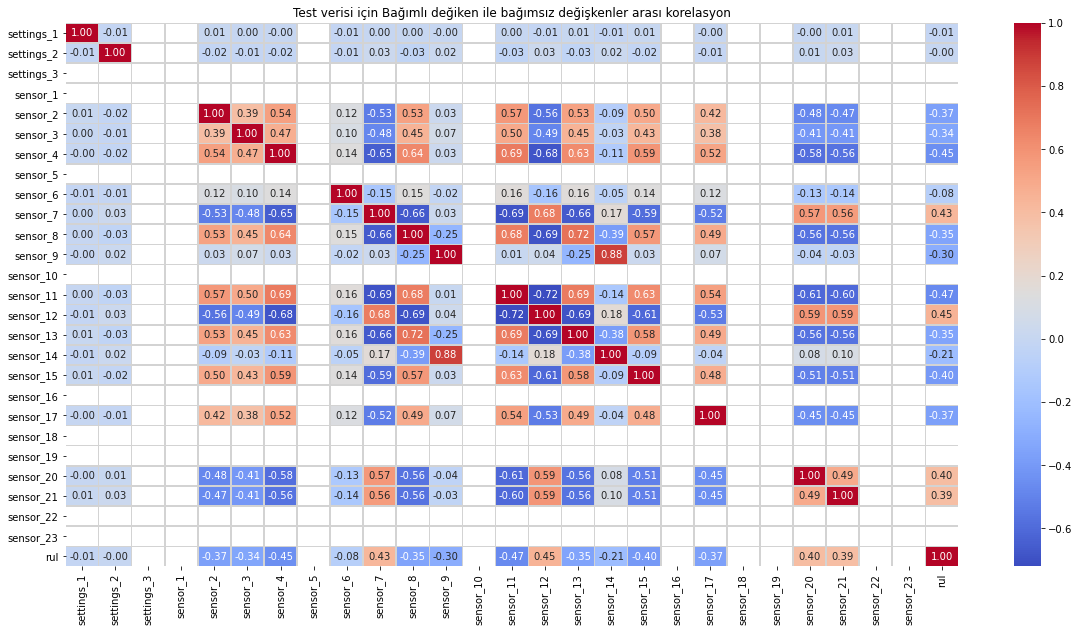

In [27]:
del test_df['id']

test_df.set_index('cycle', inplace = True)

df_corr = test_df.corr(method = 'pearson')
fig, axes = plt.subplots(figsize = (20, 10))
ax = sns.heatmap(round(df_corr,2), cmap="coolwarm", fmt='.2f', linecolor= 'lightgrey', linewidths= 0.5, annot=True)
plt.title("Test verisi için Bağımlı değiken ile bağımsız değişkenler arası korelasyon")
plt.show()

In [20]:
train_df = train_labeled.copy()
cols_nan = train_df.columns[train_df.isna().any()].tolist()
print("Blank columns: \n" + str(cols_nan) + "\n")

Blank columns: 
['sensor_22', 'sensor_23']



In [30]:
cols_constant = [column for column in train_df.columns 
                 if len(train_df[column].unique()) <= 2]
print("Columns with constant values: \n" + str(cols_constant) + "\n")

Columns with constant values: 
['settings_3', 'sensor_1', 'sensor_5', 'sensor_6', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19', 'sensor_22', 'sensor_23']



In [31]:
test_df = test_labeled.copy()
cols_nan = test_df.columns[test_df.isna().any()].tolist()
print("Blank columns: \n" + str(cols_nan) + "\n")

Blank columns: 
['sensor_22', 'sensor_23']



In [32]:
cols_constant = [column for column in test_df.columns 
                 if len(test_df[column].unique()) <= 2]
print("Columns with constant values: \n" + str(cols_constant) + "\n")

Columns with constant values: 
['settings_3', 'sensor_1', 'sensor_5', 'sensor_6', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19', 'sensor_22', 'sensor_23']



In [33]:
train_df = train_df.drop(columns = cols_nan + cols_constant)
test_df = test_df.drop(columns = cols_nan + cols_constant)
train_labeled = train_labeled.drop(columns = cols_nan + cols_constant)
test_labeled = test_labeled.drop(columns = cols_nan+cols_constant)

In [37]:
test_df

,id,cycle,settings_1,settings_2,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21,rul
0,1,1,0.0023,0.0003,643.02,1585.29,1398.21,553.90,2388.04,9050.17,47.20,521.72,2388.03,8125.55,8.4052,392,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,641.71,1588.45,1395.42,554.85,2388.01,9054.42,47.50,522.16,2388.06,8139.62,8.3803,393,39.02,23.3916,141
2,1,3,0.0003,0.0001,642.46,1586.94,1401.34,554.11,2388.05,9056.96,47.50,521.97,2388.03,8130.10,8.4441,393,39.08,23.4166,140
3,1,4,0.0042,0.0000,642.44,1584.12,1406.42,554.07,2388.03,9045.29,47.28,521.38,2388.05,8132.90,8.3917,391,39.00,23.3737,139
4,1,5,0.0014,0.0000,642.51,1587.19,1401.92,554.16,2388.01,9044.55,47.31,522.15,2388.03,8129.54,8.4031,390,38.99,23.4130,138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,643.24,1599.45,1415.79,553.41,2388.02,9142.37,47.69,520.69,2388.00,8213.28,8.4715,394,38.65,23.1974,24
13092,100,195,-0.0011,-0.0001,643.22,1595.69,1422.05,553.22,2388.05,9140.68,47.60,521.05,2388.09,8210.85,8.4512,395,38.57,23.2771,23
13093,100,196,-0.0006,-0.0003,643.44,1593.15,1406.82,553.04,2388.11,9146.81,47.57,521.18,2388.04,8217.24,8.4569,395,38.62,23.2051,22
13094,100,197,-0.0038,0.0001,643.26,1594.99,1419.36,553.37,2388.07,9148.85,47.61,521.33,2388.08,8220.48,8.4711,395,38.66,23.2699,21


In [38]:
# her bir motor id'si icin bos veya sabit degerlerden olusan sutunlara bakalim

for motor_id, motor_df in train_df.groupby('id'):
    cols_nan = train_df.columns[motor_df.isna().any()].tolist()
    cols_constant = [cols for cols in motor_df.columns
                     if len(motor_df[cols].unique()) < 1 and cols != 'id' ]
    
    if cols_nan:
        print(' id\'si {} olan motor bos sutunlar icermektedir: {}\n'.format(motor_id, cols_nan))
    if cols_constant:
        print(' id\'si {} olan motor sabit degerlerden olusan sutunlar icermektedir: {}\n'.format(motor_id, cols_constant))

In [39]:
del train_labeled['id']
train_labeled.set_index('cycle', inplace = True)
train_labeled
corr_df = train_labeled.corr(method = 'pearson')
corr2_df = pd.DataFrame(np.tril(corr_df.values), columns=corr_df.columns, index= corr_df.index)
correlation = []

for col in corr2_df.columns:
    col_dizisi = corr2_df[col]
    ind = np.logical_or(-0.6 > col_dizisi, 0.6 < col_dizisi)
    
    for ind, value in zip(col_dizisi[ind].index, col_dizisi[ind].values):
        if(ind, col, value) not in correlation and ind != col and ind=='rul':
            correlation.append((col, ind, value))
            
print('Yuksek korelasyonlara sahip degiskenler: \n')
for c in correlation:
    print(c)

Yuksek korelasyonlara sahip degiskenler: 

('sensor_2', 'rul', -0.6064839743785985)
('sensor_4', 'rul', -0.6789482333860427)
('sensor_7', 'rul', 0.6572226620546537)
('sensor_11', 'rul', -0.6962281014553727)
('sensor_12', 'rul', 0.6719831036133275)
('sensor_15', 'rul', -0.6426670441974635)
('sensor_17', 'rul', -0.6061535537829565)
('sensor_20', 'rul', 0.6294284994377553)
('sensor_21', 'rul', 0.6356620421802941)


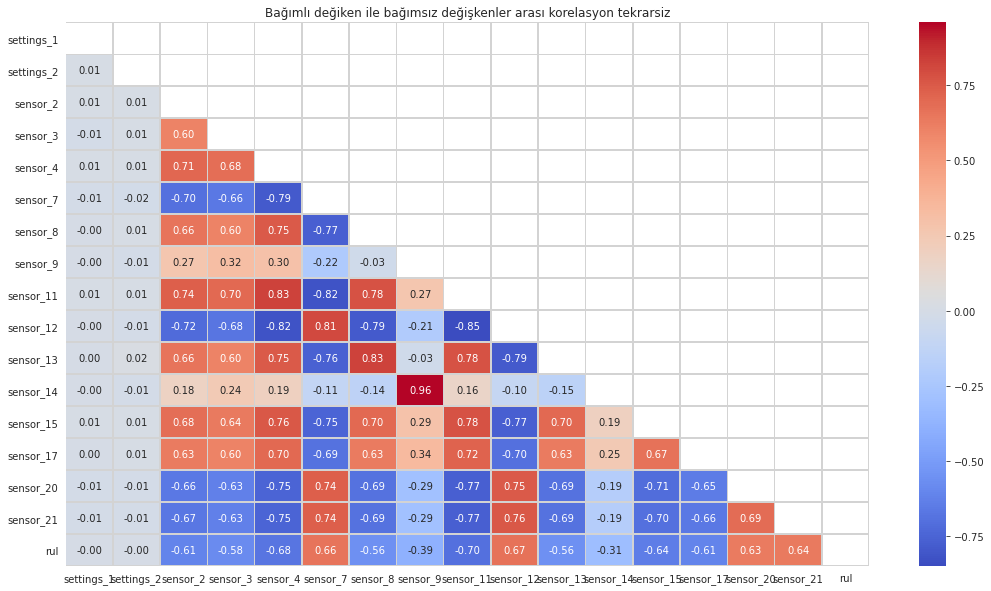

In [40]:
df_corr = train_labeled.corr(method = 'pearson')
mask = np.zeros_like(df_corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize = (18, 10))
    ax = sns.heatmap(round(df_corr,2), mask = mask, cmap="coolwarm", fmt='.2f', linecolor='lightgrey', linewidths=0.5, annot=True)
plt.title("Bağımlı değiken ile bağımsız değişkenler arası korelasyon tekrarsiz")
plt.show()

In [41]:
del train_labeled['rul']
correlation = []

for col in corr2_df.columns:
    col_dizisi = corr2_df[col]
    ind = np.logical_or(-0.8 > col_dizisi, 0.8 < col_dizisi)
    
    for ind, value in zip(col_dizisi[ind].index, col_dizisi[ind].values):
        if(ind, col, value) not in correlation and ind != col:
            correlation.append((col, ind, value))
            
print('Yuksek korelasyonlara sahip degiskenler: \n')
for c in correlation:
    print(c)

Yuksek korelasyonlara sahip degiskenler: 

('sensor_4', 'sensor_11', 0.8301356963159815)
('sensor_4', 'sensor_12', -0.815590516105214)
('sensor_7', 'sensor_11', -0.8228050249957691)
('sensor_7', 'sensor_12', 0.812712601325414)
('sensor_8', 'sensor_13', 0.8260843322333569)
('sensor_9', 'sensor_14', 0.9631566003059776)
('sensor_11', 'sensor_12', -0.8468835930051095)


In [42]:
df_corr['sensor_7'].loc['sensor_11']

-0.8228050249957691

In [43]:
df_corr['sensor_7'].loc['sensor_4']

-0.7931295615103564

## 1.6 Zaman ve Dagilim grafikleri

In [45]:
# her motor icin en fazla calistirma sayisini bulma
mapper = {}
for motor in train_df['id'].unique():
    mapper[motor] = train_df['cycle'].loc[train_df['id'] == motor].max()
    
mapper_by_lenth = sorted(mapper.items(), key = lambda kv:kv[1])

In [46]:
mapper_by_lenth

# en az cycle ceken motorun id'si 39
# orta sayida cycle ceken motorun id'si int(len(mapper)/2)
# en fazla cycle ceken motorun id'si 69

[(39, 128),
 (91, 135),
 (57, 137),
 (70, 137),
 (24, 147),
 (58, 147),
 (8, 150),
 (65, 153),
 (77, 154),
 (90, 154),
 (93, 155),
 (27, 156),
 (98, 156),
 (19, 158),
 (36, 158),
 (45, 158),
 (13, 163),
 (29, 163),
 (28, 165),
 (74, 166),
 (23, 168),
 (12, 170),
 (37, 170),
 (60, 172),
 (63, 174),
 (87, 178),
 (3, 179),
 (14, 180),
 (62, 180),
 (35, 181),
 (61, 185),
 (80, 185),
 (99, 185),
 (6, 188),
 (40, 188),
 (85, 188),
 (4, 189),
 (32, 191),
 (1, 192),
 (44, 192),
 (55, 193),
 (30, 194),
 (38, 194),
 (18, 195),
 (21, 195),
 (34, 195),
 (53, 195),
 (42, 196),
 (50, 198),
 (26, 199),
 (68, 199),
 (79, 199),
 (33, 200),
 (100, 200),
 (9, 201),
 (22, 202),
 (66, 202),
 (97, 202),
 (15, 207),
 (43, 207),
 (71, 208),
 (16, 209),
 (76, 210),
 (51, 213),
 (52, 213),
 (72, 213),
 (73, 213),
 (88, 213),
 (47, 214),
 (82, 214),
 (49, 215),
 (41, 216),
 (89, 217),
 (10, 222),
 (75, 229),
 (25, 230),
 (48, 231),
 (59, 231),
 (78, 231),
 (20, 234),
 (31, 234),
 (11, 240),
 (81, 240),
 (46, 256

In [47]:
def plots_by_id(df, id, wind_size):
    df.set_index('cycle', inplace = True)
    del df['id']
    
    cols = df.columns
    fig, axes = plt.subplots(len(cols), figsize = (15,12))  #plot sayisi==her bir degisken icin plot cizilir
    
    for col, axis in zip(cols, axes):
        df[col].plot(ax = axis)                            
        df[col].rolling(wind_size).median().plot(ax = axis) 
        df[col].rolling(wind_size).mean().plot(style = '--', legend = True, ax = axis)  
        
    fig.suptitle('id: {}'.format(id))
    sns.set()
    
def labels(x, y, *axes):
    for axis in axes:
        if x: axis.set_xlabel(x)
        if y: axis.set_ylabel(y)

def plot_hist_by_id(df, id, wind_size):
    df.set_index('cycle', inplace = True)
    del df['id']
    cols = df.columns
    n_cols = min(len(cols),5)                 #plot edilecek kolon sayısı    5=min(16,5)       columns
    n_rows = int(np.ceil(len(cols)/n_cols))   #plot edilecek satır sayısı    4=ceil(16/5==3.2) rows
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize = (18,16))
    axes = axes.flatten()  #returns flattened version of the array
    for col, axis in zip(cols, axes):
        sns.distplot(df[[col]], ax = axis, label = col)     #sns.histplot(x=deger_araligi, y=tekrar_sayisi, degisken_adi)
        labels(col, 'p', axis)
    fig.suptitle('id: {}'.format(id))

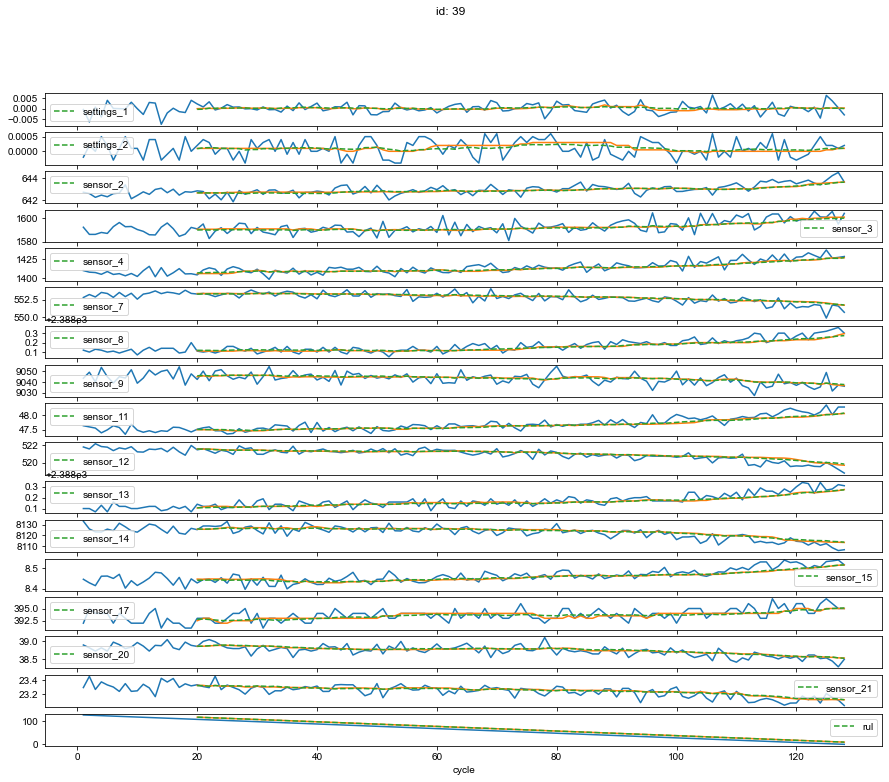

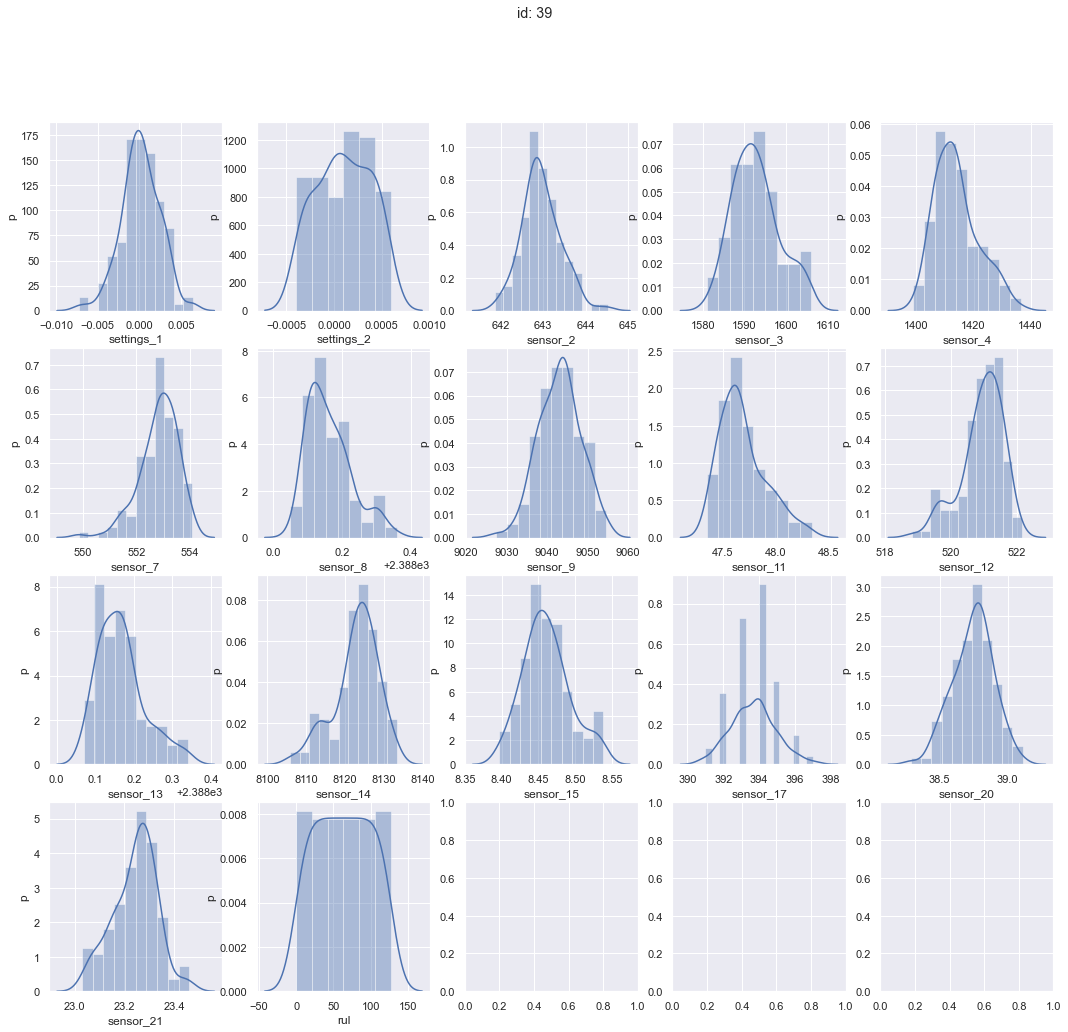

In [48]:
#en az cycle ceken motor
wind_size = 20
unit_to_plot = mapper_by_lenth[0][0]
plots_by_id(train_df.loc[train_df['id']==unit_to_plot].copy(), unit_to_plot, wind_size)
plt.show()

plot_hist_by_id(train_df.loc[train_df['id']==unit_to_plot].copy(), unit_to_plot, wind_size)
plt.show()

In [50]:
train_df['sensor_17'].value_counts()

393    5445
392    4578
394    4063
395    2339
391    2022
396    1185
390     452
397     436
398      72
389      30
399       7
400       1
388       1
Name: sensor_17, dtype: int64

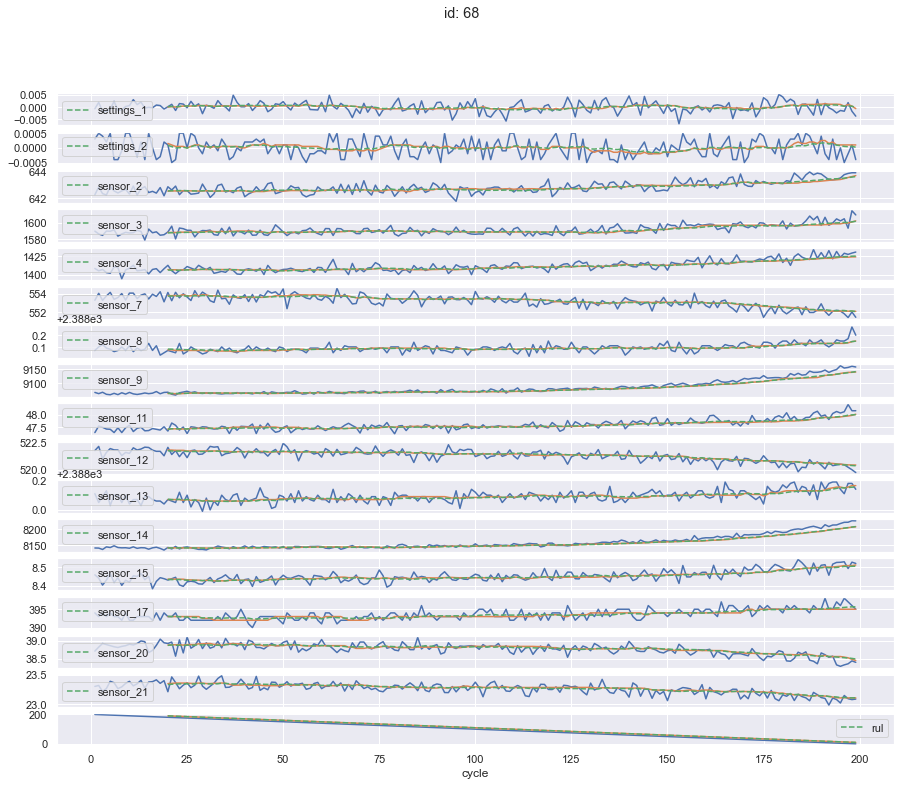

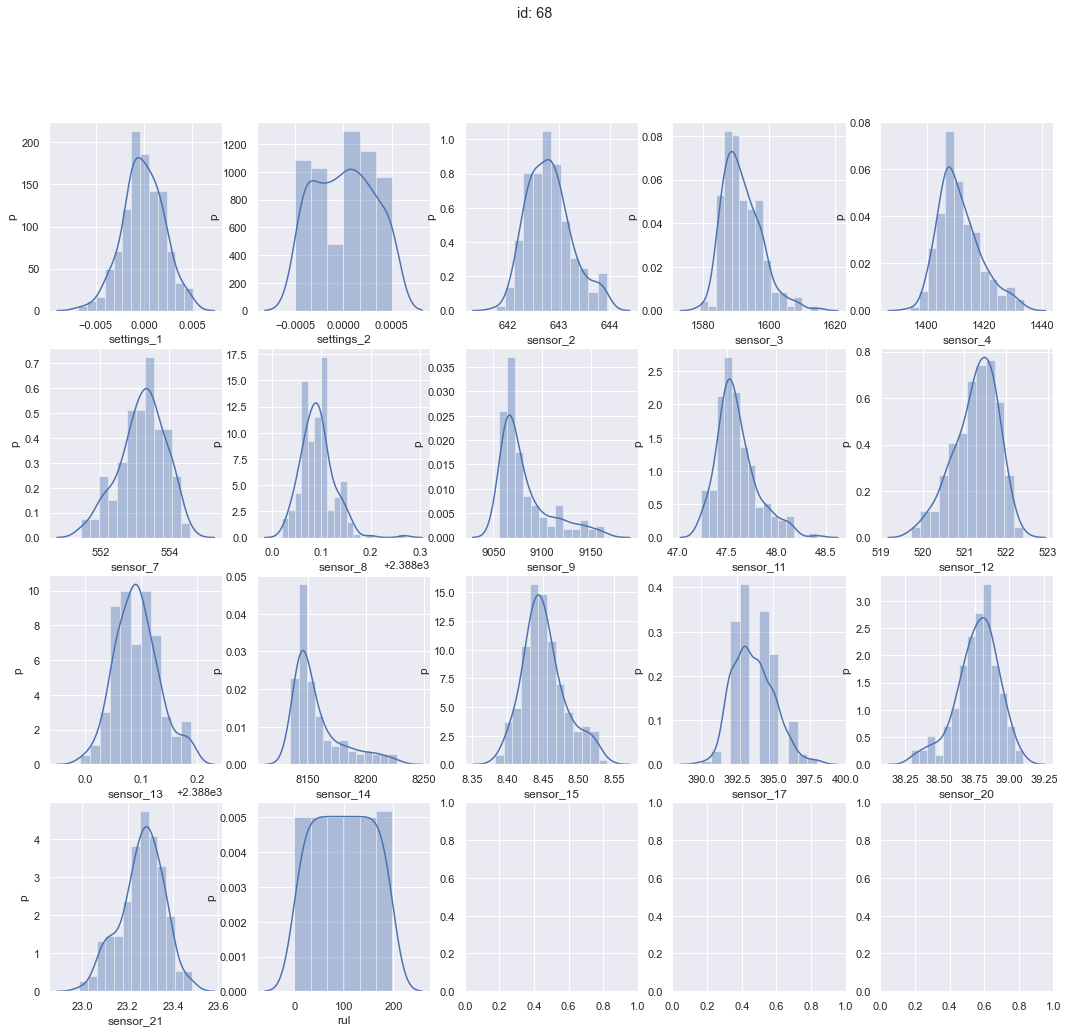

In [51]:
# ortalama cycle ceken motor
unit_to_plot = mapper_by_lenth[int(len(mapper)/2)][0]
plots_by_id(train_df.loc[train_df['id']==unit_to_plot], unit_to_plot, wind_size)
plot_hist_by_id(train_df.loc[train_df['id']==unit_to_plot], unit_to_plot,  wind_size)

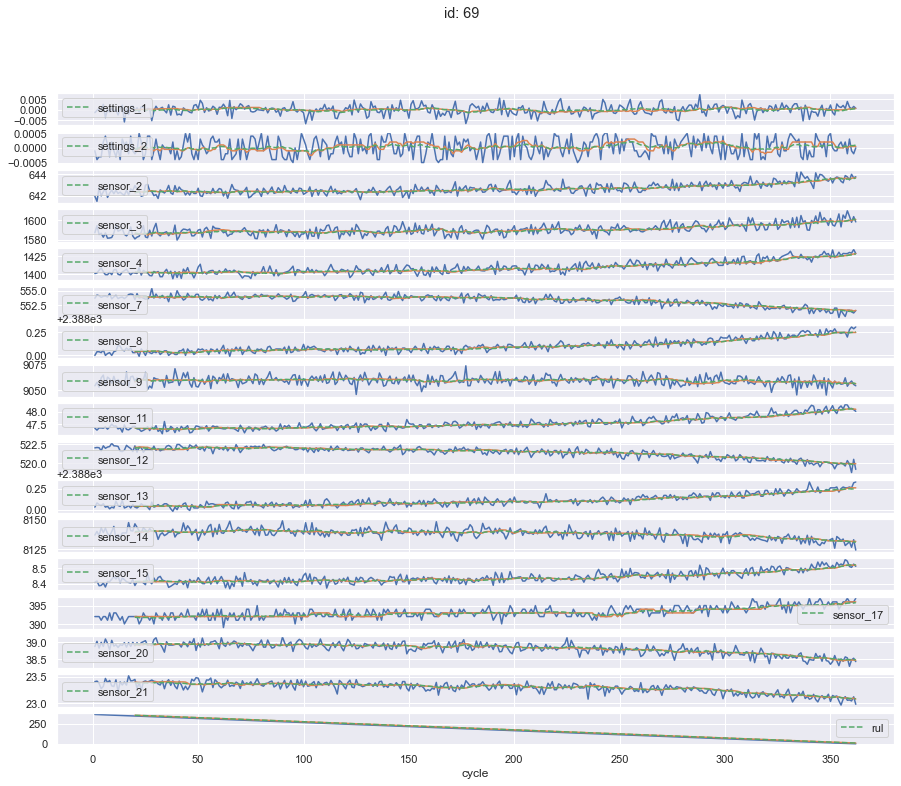

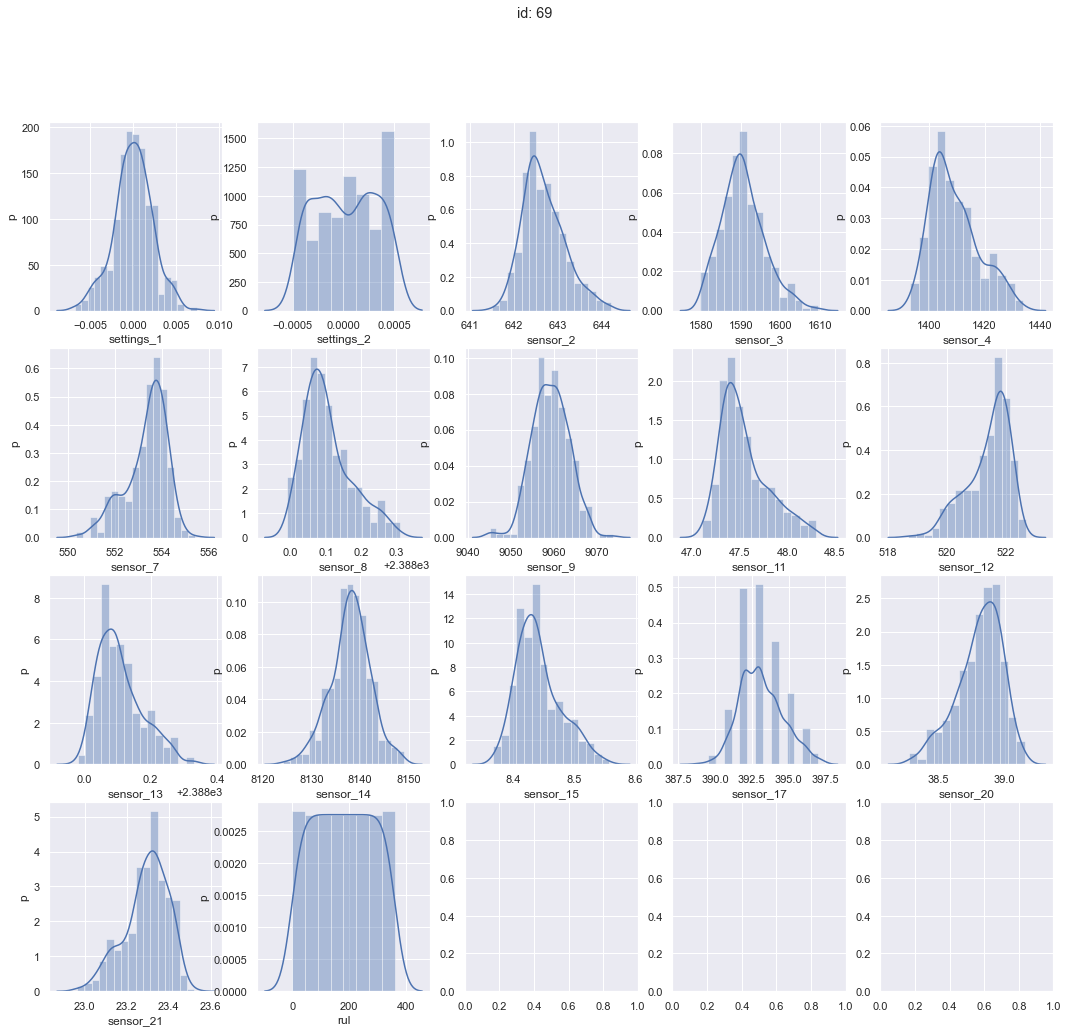

In [52]:
# en fazla cycle ceken motor
unit_to_plot = mapper_by_lenth[-1][0]
plots_by_id(train_df.loc[train_df['id']==unit_to_plot], unit_to_plot, wind_size)
plot_hist_by_id(train_df.loc[train_df['id']==unit_to_plot], unit_to_plot, wind_size)

## 1.7 Degiskenleri grafiklere bakarak analiz etme

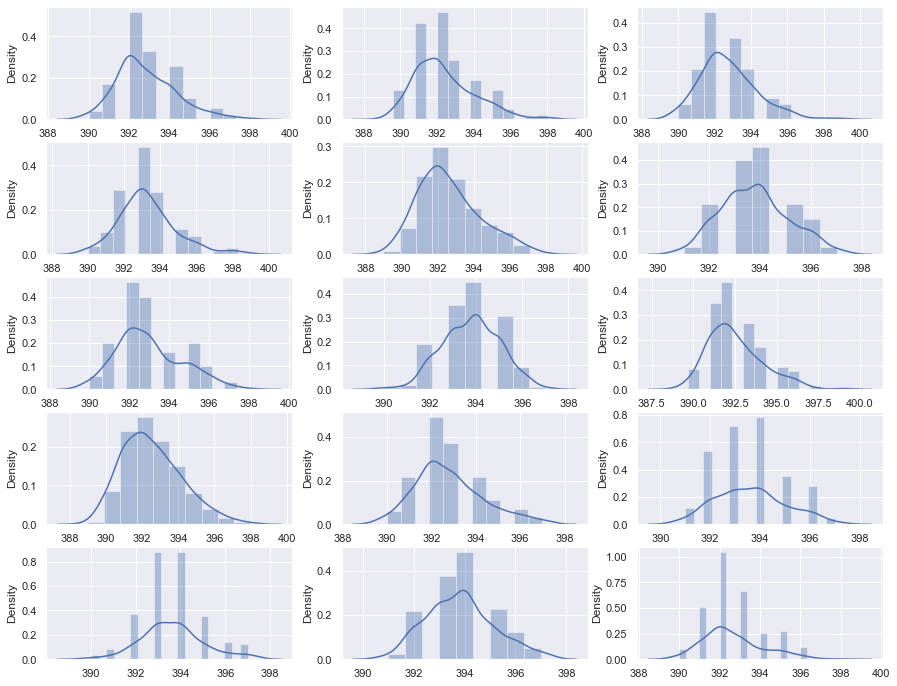

In [53]:
# distplotlara bakacak olursak sensor_17 digerlerine gore daha farkli kaliyor.

#ilk 15 tane motorun sensor_17 degiskenine bakalim
df_per_id = [df for mid, df in train_df.groupby('id')]
fig, axes = plt.subplots(5, 3, figsize = (15,12))
axes = axes.flatten()
for df_now, axis in zip(df_per_id, axes):
    sns.distplot(df_now[['sensor_17']], ax = axis)


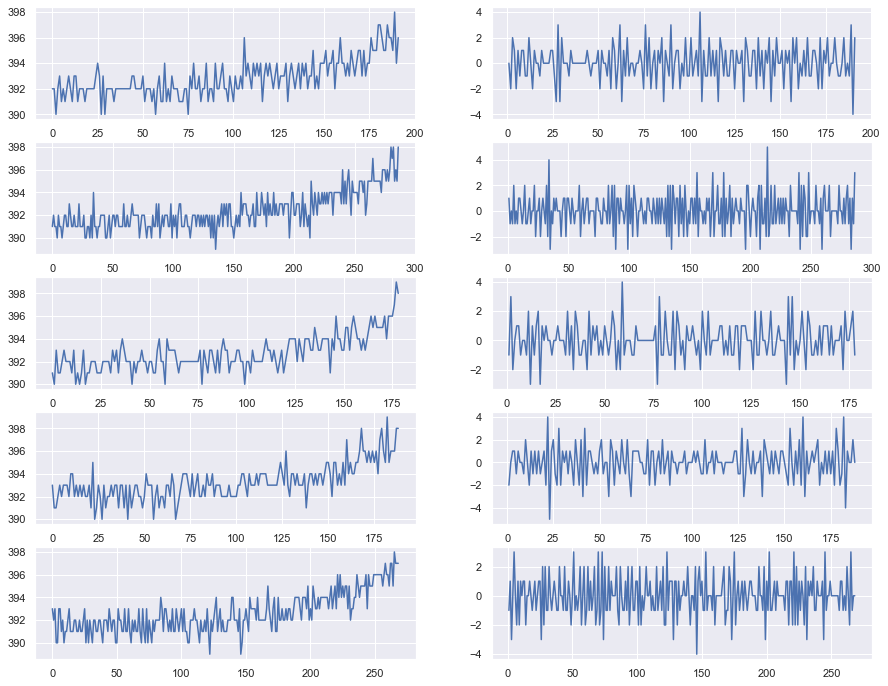

In [54]:
#ilk 5 mototrun sensor_17 kolonunun değerleri ve ölçeklenmiş değerleri

fig, axes = plt.subplots(5, 2, figsize = (15,12))
count = 0
for df_now, axis in zip(df_per_id, range(5)):
    sensor17 =df_now['sensor_17']
    axes[count, 0].plot(sensor17.values)
    axes[count, 1].plot(sensor17.diff().values)
    count += 1

In [55]:
step_sizes = []
for mid, df in train_df.groupby('id'):
    step_sizes += list(set(df['sensor_17'].unique()))
step_sizes = set(step_sizes)                           #(küme, unique değerleri gösterir)
print(step_sizes)


{388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400}


- sensor_17 20631 tane satırda sadece yukarıdaki değerler arasında değişerek bir sütun oluşturuyor. Bu da quantizasyon hatasının göstergesi diyebiliriz. Yani, değerler alınırken ortamdan, sensörden veya herhangi bir sebepten kaynaklı olarak değerlerin bastırılması anlamına gelmektedir.

### Verisetini motor id lerine göre ayırma

In [59]:
train_df.dropna(axis = 1, inplace = True)

In [60]:
df = train_df.copy()

In [61]:
df

,id,cycle,settings_1,settings_2,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21,rul
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,3
20628,100,198,0.0004,0.0000,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,1


In [62]:
df_train = df.copy()

In [63]:
dfs_by_unit = {}

RULs_max = {}
for mid in df_train['id'].unique():
    dfs_by_unit[mid] = df.loc[df_train['id']==mid].copy()

### Motorların hizmet ömrü :

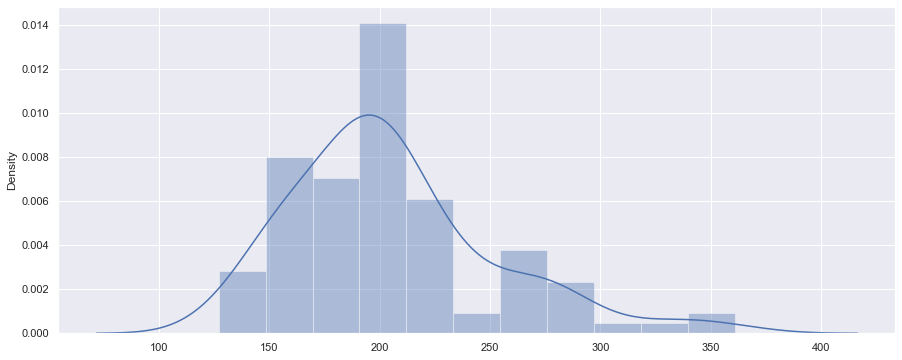

In [64]:
RULs_max = dict([(mid, v['rul'].values[0]) for mid, v in df_train.groupby('id')])
fig = plt.figure(figsize=(15, 6))
ax2 = sns.distplot(pd.Series(RULs_max), label = 'cycles')

- 125 < hizmet omru < 350 ==> 

- Motorların RUL değerleri arası varyansı büyüktür.



# 2.Veri setinin Eğitim için hazırlanması 

In [89]:
model_path = 'multiclass_model.h5'

In [65]:
train_df

,id,cycle,settings_1,settings_2,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21,rul
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,3
20628,100,198,0.0004,0.0000,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,1


In [66]:
test_df

,id,cycle,settings_1,settings_2,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21,rul
0,1,1,0.0023,0.0003,643.02,1585.29,1398.21,553.90,2388.04,9050.17,47.20,521.72,2388.03,8125.55,8.4052,392,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,641.71,1588.45,1395.42,554.85,2388.01,9054.42,47.50,522.16,2388.06,8139.62,8.3803,393,39.02,23.3916,141
2,1,3,0.0003,0.0001,642.46,1586.94,1401.34,554.11,2388.05,9056.96,47.50,521.97,2388.03,8130.10,8.4441,393,39.08,23.4166,140
3,1,4,0.0042,0.0000,642.44,1584.12,1406.42,554.07,2388.03,9045.29,47.28,521.38,2388.05,8132.90,8.3917,391,39.00,23.3737,139
4,1,5,0.0014,0.0000,642.51,1587.19,1401.92,554.16,2388.01,9044.55,47.31,522.15,2388.03,8129.54,8.4031,390,38.99,23.4130,138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,643.24,1599.45,1415.79,553.41,2388.02,9142.37,47.69,520.69,2388.00,8213.28,8.4715,394,38.65,23.1974,24
13092,100,195,-0.0011,-0.0001,643.22,1595.69,1422.05,553.22,2388.05,9140.68,47.60,521.05,2388.09,8210.85,8.4512,395,38.57,23.2771,23
13093,100,196,-0.0006,-0.0003,643.44,1593.15,1406.82,553.04,2388.11,9146.81,47.57,521.18,2388.04,8217.24,8.4569,395,38.62,23.2051,22
13094,100,197,-0.0038,0.0001,643.26,1594.99,1419.36,553.37,2388.07,9148.85,47.61,521.33,2388.08,8220.48,8.4711,395,38.66,23.2699,21


## 2.1 Etiketlerin oluşturulması

### _____________Label2 Sınıfları_____
- normal (0)==> rul 30 cycle'dan fazla
- uyarı (1)==> rul 15-30 arasi cycle
- #alarm (2)==> rul 15 cycle'dan daha az 

In [68]:
# - Label1: ikili sınıflandırma {0,1} için bağımsız değişken
# - Label2: çoklu sınıf sınıflandırma {0,1,2} için bağımsız değişken

train_df['label1']=np.where(train_df['rul']<=30, 1, 0)
train_df['label2']=train_df['label1']
train_df.loc[train_df['rul']<=15,'label2']=2

In [69]:
test_df['label1']=np.where(test_df['rul']<=30, 1, 0)
test_df['label2']=test_df['label1']
test_df.loc[test_df['rul']<=15,'label2']=2

In [70]:
cols_to_scale=train_df.columns.difference(['id','cycle','label1','label2','rul'])

In [71]:
cols_to_scale

Index(['sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15',
       'sensor_17', 'sensor_2', 'sensor_20', 'sensor_21', 'sensor_3',
       'sensor_4', 'sensor_7', 'sensor_8', 'sensor_9', 'settings_1',
       'settings_2'],
      dtype='object')

In [74]:
# 0-1 normalization
train_df['cycle_norm']=train_df['cycle']
cols_normalize=train_df.columns.difference(['id','cycle','rul', 'label1','label2'])
min_max_scaler=preprocessing.MinMaxScaler()
norm_train_df=pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]),
                           columns=cols_normalize,
                           index=train_df.index)
train_join_df=train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df=train_join_df.reindex(columns=train_df.columns)
train_df=train_df.reset_index(drop=True)
print(print(train_df.head()))

   id  cycle  settings_1  settings_2  sensor_2  sensor_3  sensor_4  sensor_7  \
0   1      1    0.459770    0.166667  0.183735  0.406802  0.309757  0.726248   
1   1      2    0.609195    0.250000  0.283133  0.453019  0.352633  0.628019   
2   1      3    0.252874    0.750000  0.343373  0.369523  0.370527  0.710145   
3   1      4    0.540230    0.500000  0.343373  0.256159  0.331195  0.740741   
4   1      5    0.390805    0.333333  0.349398  0.257467  0.404625  0.668277   

   sensor_8  sensor_9  ...  sensor_13  sensor_14  sensor_15  sensor_17  \
0  0.242424  0.109755  ...   0.205882   0.199608   0.363986   0.333333   
1  0.212121  0.100242  ...   0.279412   0.162813   0.411312   0.333333   
2  0.272727  0.140043  ...   0.220588   0.171793   0.357445   0.166667   
3  0.318182  0.124518  ...   0.294118   0.174889   0.166603   0.333333   
4  0.242424  0.149960  ...   0.235294   0.174734   0.402078   0.416667   

   sensor_20  sensor_21  rul  label1  label2  cycle_norm  
0   0.713178   

In [75]:
train_df.describe()

,id,cycle,settings_1,settings_2,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,...,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21,rul,label1,label2,cycle_norm
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,...,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000
mean,51.506568,108.807862,0.499490,0.501959,0.443052,0.424746,0.450435,0.566459,0.297957,0.195248,...,0.317871,0.226095,0.451118,0.434221,0.524241,0.546127,107.807862,0.150259,0.227813,0.298637
std,29.227633,68.880990,0.125708,0.244218,0.150618,0.133664,0.151935,0.142527,0.107554,0.099089,...,0.105763,0.098442,0.144306,0.129064,0.140114,0.149476,68.880990,0.357334,0.575358,0.190806
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,26.000000,52.000000,0.413793,0.333333,0.335843,0.331807,0.339467,0.476651,0.227273,0.140761,...,0.235294,0.171870,0.346287,0.333333,0.434109,0.452361,51.000000,0.000000,0.000000,0.141274
50%,52.000000,104.000000,0.500000,0.500000,0.430723,0.415522,0.435348,0.578100,0.287879,0.174684,...,0.308824,0.209516,0.438630,0.416667,0.534884,0.557443,103.000000,0.000000,0.000000,0.285319
75%,77.000000,156.000000,0.586207,0.750000,0.539157,0.508829,0.545324,0.669887,0.363636,0.213991,...,0.382353,0.249613,0.541362,0.500000,0.627907,0.652582,155.000000,0.000000,0.000000,0.429363
max,100.000000,362.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,361.000000,1.000000,2.000000,1.000000


In [76]:
#test dataseti icin 0-1 normalization

test_df['cycle_norm']=test_df['cycle']
norm_test_df=pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]),
                          columns=cols_normalize,
                          index=test_df.index)
test_join_df=test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df=test_join_df.reindex(columns=test_df.columns)
test_df=test_df.reset_index(drop=True)
print(test_df.head())


   id  cycle  settings_1  settings_2  sensor_2  sensor_3  sensor_4  sensor_7  \
0   1      1    0.632184    0.750000  0.545181  0.310661  0.269413  0.652174   
1   1      2    0.344828    0.250000  0.150602  0.379551  0.222316  0.805153   
2   1      3    0.517241    0.583333  0.376506  0.346632  0.322248  0.685990   
3   1      4    0.741379    0.500000  0.370482  0.285154  0.408001  0.679549   
4   1      5    0.580460    0.500000  0.391566  0.352082  0.332039  0.694042   

   sensor_8  sensor_9  ...  sensor_13  sensor_14  sensor_15  sensor_17  \
0  0.212121  0.127614  ...   0.220588   0.132160   0.308965   0.333333   
1  0.166667  0.146684  ...   0.264706   0.204768   0.213159   0.416667   
2  0.227273  0.158081  ...   0.220588   0.155640   0.458638   0.416667   
3  0.196970  0.105717  ...   0.250000   0.170090   0.257022   0.250000   
4  0.166667  0.102396  ...   0.220588   0.152751   0.300885   0.166667   

   sensor_20  sensor_21  rul  label1  label2  cycle_norm  
0   0.558140   

In [77]:
test_df.describe()

,id,cycle,settings_1,settings_2,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,...,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21,rul,label1,label2,cycle_norm
count,13096.000000,13096.000000,13096.000000,13096.000000,13096.000000,13096.000000,13096.000000,13096.000000,13096.000000,13096.000000,...,13096.000000,13096.000000,13096.000000,13096.000000,13096.000000,13096.000000,13096.000000,13096.000000,13096.000000,13096.000000
mean,51.543907,76.836515,0.499358,0.503532,0.381051,0.371903,0.379564,0.629231,0.259037,0.164576,...,0.280919,0.201299,0.388395,0.380969,0.583335,0.609697,141.238470,0.025351,0.029933,0.210073
std,28.289423,53.057749,0.126591,0.245025,0.120753,0.109075,0.112902,0.109708,0.087033,0.051316,...,0.083727,0.052578,0.111617,0.102798,0.109830,0.116156,58.980114,0.157196,0.195455,0.146974
min,1.000000,1.000000,0.028736,0.000000,-0.024096,-0.043601,0.036124,0.165862,-0.015152,0.012564,...,0.014706,0.044174,0.030396,0.083333,0.131783,0.056890,7.000000,0.000000,0.000000,0.000000
25%,28.000000,33.000000,0.413793,0.333333,0.297440,0.295618,0.298785,0.557166,0.196970,0.131428,...,0.220588,0.167045,0.310504,0.333333,0.511628,0.534935,102.000000,0.000000,0.000000,0.088643
50%,52.000000,69.000000,0.500000,0.500000,0.376506,0.369523,0.374578,0.636071,0.257576,0.159697,...,0.279412,0.198421,0.384763,0.416667,0.589147,0.614471,140.000000,0.000000,0.000000,0.188366
75%,76.000000,113.000000,0.586207,0.750000,0.460843,0.443046,0.452397,0.706924,0.318182,0.190164,...,0.338235,0.229229,0.459407,0.416667,0.658915,0.689589,179.000000,0.000000,0.000000,0.310249
max,100.000000,303.000000,0.948276,1.083333,0.930723,0.795945,0.862762,0.964573,0.606061,0.598133,...,0.647059,0.622046,0.833013,0.750000,0.984496,1.032450,340.000000,1.000000,2.000000,0.836565


In [78]:
test_df.tail()

,id,cycle,settings_1,settings_2,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,...,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21,rul,label1,label2,cycle_norm
13091,100,194,0.781609,0.500000,0.611446,0.619359,0.566172,0.573269,0.181818,0.541326,...,0.176471,0.584890,0.564063,0.500000,0.395349,0.418669,24,1,1,0.534626
13092,100,195,0.436782,0.416667,0.605422,0.537388,0.671843,0.542673,0.227273,0.533743,...,0.308824,0.572350,0.485956,0.583333,0.333333,0.528721,23,1,1,0.537396
13093,100,196,0.465517,0.250000,0.671687,0.482014,0.414754,0.513688,0.318182,0.561249,...,0.235294,0.605326,0.507888,0.583333,0.372093,0.429301,22,1,1,0.540166
13094,100,197,0.281609,0.583333,0.617470,0.522128,0.626435,0.566828,0.257576,0.570403,...,0.294118,0.622046,0.562524,0.583333,0.403101,0.518779,21,1,1,0.542936
13095,100,198,0.574713,0.750000,0.524096,0.666667,0.721472,0.423510,0.242424,0.598133,...,0.250000,0.591908,0.636399,0.666667,0.434109,0.402237,20,1,1,0.545706


## 2.2 Egitim verisini LSTM'e feed etmek için gereken formata dönüştürmek

### 2d=>3d
- (satir,sutun)==>(satir,ardışık_dizi_uzunlugu,sutun)

In [79]:
train_df.columns

Index(['id', 'cycle', 'settings_1', 'settings_2', 'sensor_2', 'sensor_3',
       'sensor_4', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11',
       'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17',
       'sensor_20', 'sensor_21', 'rul', 'label1', 'label2', 'cycle_norm'],
      dtype='object')

In [80]:
sensor_cols=['sensor_2', 'sensor_3', 'sensor_4', 
             'sensor_7', 'sensor_8','sensor_9',
             'sensor_11','sensor_12','sensor_13', 
             'sensor_14', 'sensor_15', 'sensor_17',
             'sensor_20',]

sequence_cols=['settings_1','settings_2','cycle_norm']

sequence_cols.extend(sensor_cols)

In [81]:
# LSTM verileri ardışık olarak öğrenme kapasitesine sahiptir. 
# Zaman serisi sınıflandırma probleminde de veriler ardışık olarak öğrenilmesi gerekmektedir.
# Bunun için verimizi 50'şerlik ardışık diziler şeklinde eğiteceğiz.
# Bunun için aşağıdaki fonksiyon kullanılacaktır.

sequence_length=50

In [82]:
# *(satır_sayısı, time_steps,            özellik_sayısı)
# *(gözlem,       ardığık_dizi_uzunluğu, sütun)

def gen_sequence(id_df, seq_lenth, seq_cols):
    data_matrix=id_df[seq_cols].values          # (value, column)==> 2D array       for ex: (192, 50)
    num_elements=data_matrix.shape[0]           # 1...192 ==> num_elements
    print(data_matrix.shape)
    
    # id=1  rows=192
    # (0,142)-->(50,192)
    # 0 50 => 1 51 => 2 52 =>...=> 141 191 => 142 192
    # toplam = (192-50)/1=142 tane 50'şerlik 
    
    for start, stop in zip(range(0, num_elements-seq_lenth), range(seq_lenth, num_elements)): # zip((start=0..142) --> (stop=50..192))
        yield data_matrix[start:stop, :]

In [83]:
#sequence generator
seq_gen=[]
mahmut=0

for id in train_df['id'].unique():
    seq_gen.append(list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)))
    print(len(seq_gen[mahmut]))
    mahmut+=1

#=======Train Vektoru======
# diziyi numpy array'e dönüştürme                       
seq_array=np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

#toplam == 20631. seq_lenth==50 -->  50*100(motor)=5000 --> 20631-5000=15631 (satır sayısı düşecektir).

(192, 16)
142
(287, 16)
237
(179, 16)
129
(189, 16)
139
(269, 16)
219
(188, 16)
138
(259, 16)
209
(150, 16)
100
(201, 16)
151
(222, 16)
172
(240, 16)
190
(170, 16)
120
(163, 16)
113
(180, 16)
130
(207, 16)
157
(209, 16)
159
(276, 16)
226
(195, 16)
145
(158, 16)
108
(234, 16)
184
(195, 16)
145
(202, 16)
152
(168, 16)
118
(147, 16)
97
(230, 16)
180
(199, 16)
149
(156, 16)
106
(165, 16)
115
(163, 16)
113
(194, 16)
144
(234, 16)
184
(191, 16)
141
(200, 16)
150
(195, 16)
145
(181, 16)
131
(158, 16)
108
(170, 16)
120
(194, 16)
144
(128, 16)
78
(188, 16)
138
(216, 16)
166
(196, 16)
146
(207, 16)
157
(192, 16)
142
(158, 16)
108
(256, 16)
206
(214, 16)
164
(231, 16)
181
(215, 16)
165
(198, 16)
148
(213, 16)
163
(213, 16)
163
(195, 16)
145
(257, 16)
207
(193, 16)
143
(275, 16)
225
(137, 16)
87
(147, 16)
97
(231, 16)
181
(172, 16)
122
(185, 16)
135
(180, 16)
130
(174, 16)
124
(283, 16)
233
(153, 16)
103
(202, 16)
152
(313, 16)
263
(199, 16)
149
(362, 16)
312
(137, 16)
87
(208, 16)
158
(213, 16)
1

(15631, 50, 16)

In [84]:
#bağımlı değişken için ardışık dizi oluşturma   

def gen_labels(id_df, seq_lenth, label):
    data_matrix=id_df[label].values
    num_elements=data_matrix.shape[0]
    return data_matrix[seq_lenth:num_elements, :]

In [85]:
label_gen=[]
mahmut=0

for id in train_df['id'].unique():
    label_gen.append(list(gen_labels(train_df[train_df['id']==id], sequence_length, ['label2'])))
    print(len(seq_gen[mahmut]))
    mahmut+=1


label_gen=[gen_labels(train_df[train_df['id']==id], sequence_length, ['label2'])
          for id in train_df['id'].unique()]

#======Test Vektoru======
label_array=np.concatenate(label_gen).astype(np.float32)
label_array.shape

142
237
129
139
219
138
209
100
151
172
190
120
113
130
157
159
226
145
108
184
145
152
118
97
180
149
106
115
113
144
184
141
150
145
131
108
120
144
78
138
166
146
157
142
108
206
164
181
165
148
163
163
145
207
143
225
87
97
181
122
135
130
124
233
103
152
263
149
312
87
158
163
163
116
179
160
104
181
149
135
190
164
243
217
138
228
128
163
167
104
85
291
105
208
233
286
152
106
135
150


(15631, 1)

In [86]:
test = pd.DataFrame(label_array)
test.value_counts()

0.0    12531
2.0     1600
1.0     1500
dtype: int64

# 3. Model Eğitme

## 3.1 LSTM mimarisini oluşturma

In [ ]:
# Multıclass Classıfıcation probleminde kayıp fonksiyonu olarak 
# sparse_categorical_crossentropy kullanılmaktadır.

In [118]:
nb_features=seq_array.shape[2]
nb_out=label_array.shape[1]

model=Sequential()

model.add(LSTM(input_shape=(sequence_length, nb_features),  # 1. Katman
               units=150,                                   # 150 nörondan oluşmaktadır.
               return_sequences=True))
model.add(Dropout(0.2))                                     # overfitting olayını önlemek için Dropout katmanı

model.add(LSTM(units=100,                                   # 2. Katman
               return_sequences=False))                     # 100 nörondan oluşmakltadır.   
model.add(Dropout(0.2))

model.add(Dense(3, activation='sigmoid'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50, 150)           100200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 150)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               100400    
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 200,903
Trainable params: 200,903
Non-trainable params: 0
_________________________________________________________________
None


In [119]:
# Bağımsız değişkenimizin sınıflarının sayısı dengesiz olduğu için kullanılan tekniktir.
# Hangi sınıfın ne kadar oranda öğrenimesi gerektiğini modele söyler. 

class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(test),
                                        y = test                                                    
                                    )
class_weights = dict(zip(np.unique(test), class_weights))
class_weights

{0.0: 0.41579549384193865, 1.0: 3.4735555555555555, 2.0: 3.2564583333333332}

## 3.2 Modeli Eğitme Fonksiyonu

In [120]:
# eğit fonksiyonu
history=model.fit(seq_array, label_array, epochs=40, batch_size=200, validation_split=0.05, verbose=2, class_weight=class_weights,
                  callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                             keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
                 )

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/40
75/75 - 24s - loss: 0.5957 - accuracy: 0.7824 - val_loss: 0.3641 - val_accuracy: 0.8529
Epoch 2/40
75/75 - 22s - loss: 0.3008 - accuracy: 0.9065 - val_loss: 0.1828 - val_accuracy: 0.9246
Epoch 3/40
75/75 - 20s - loss: 0.2398 - accuracy: 0.9232 - val_loss: 0.1377 - val_accuracy: 0.9476
Epoch 4/40
75/75 - 20s - loss: 0.2210 - accuracy: 0.9265 - val_loss: 0.1003 - val_accuracy: 0.9565
Epoch 5/40
75/75 - 20s - loss: 0.2354 - accuracy: 0.9211 - val_loss: 0.1231 - val_accuracy: 0.9591
Epoch 6/40
75/75 - 20s - loss: 0.2376 - accuracy: 0.9240 - val_loss: 0.2197 - val_accuracy: 0.9169
Epoch 7/40
75/75 - 20s - loss: 0.1966 - accuracy: 0.9380 - val_loss: 0.1485 - val_accuracy: 0.9386
Epoch 8/40
75/75 - 20s - loss: 0.1707 - accuracy: 0.9447 - val_loss: 0.1730 - val_accuracy: 0.9412
Epoch 9/40
75/75 - 20s - loss: 0.1809 - accuracy: 0.9436 - val_loss: 0

In [121]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


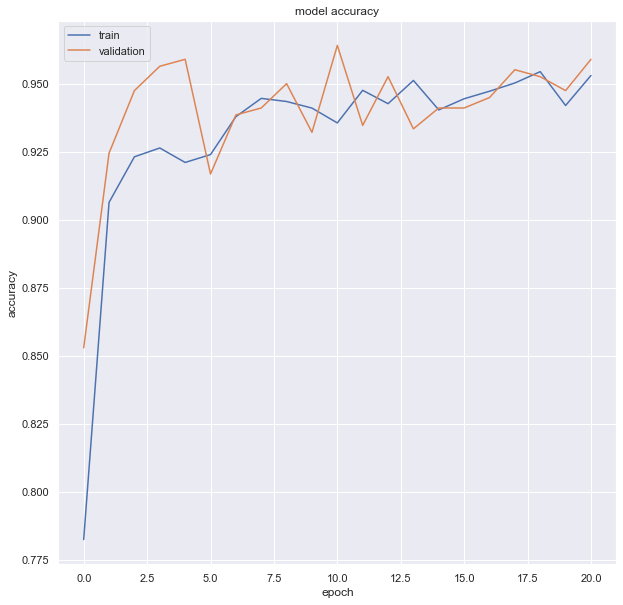

In [147]:
#accuracy

figure_acc=plt.figure(figsize=(10,10))
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy']) 
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
#figure_acc.savefig("generated/model_accuracy2.png")



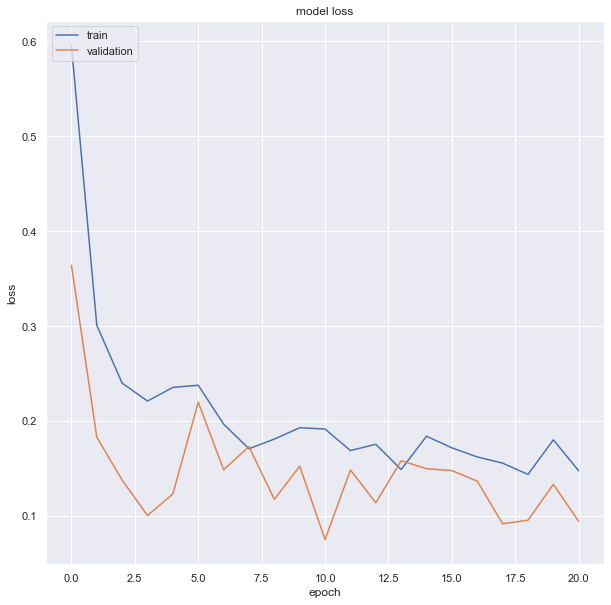

In [148]:
#loss

figure_loss = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
#figure_loss.savefig("generated/model_loss2.png")


In [124]:
# metrikler

scores= model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accuracy: {}'.format(scores[1]))

79/79 [==============================] - 6s 79ms/step - loss: 0.1093 - accuracy: 0.9544
Accuracy: 0.95438551902771


In [125]:
# tahminler

y_pred=model.predict(seq_array, verbose=1, batch_size=200)
y_true=label_array.astype(np.float32)

79/79 [==============================] - 7s 83ms/step


In [126]:
y_pred=np.round(abs(y_pred))
y_pred

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [127]:
y_true

array([[0.],
       [0.],
       [0.],
       ...,
       [2.],
       [2.],
       [2.]], dtype=float32)

In [128]:
print(y_pred.shape)    
print(y_true.shape)   

(15631, 3)
(15631, 1)


In [129]:
train_set=pd.DataFrame(y_pred)

In [130]:
train_set

,0,1,2
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
...,...,...,...
15626,0.0,0.0,1.0
15627,0.0,0.0,1.0
15628,0.0,0.0,1.0
15629,0.0,0.0,1.0


In [131]:
# multiclass olan beğımsız değişkeninin one-hot-encoded halinden tek satıra indirilmesi

y_pred = y_pred.argmax(axis=1)

In [132]:
print('Confusion matrix:  \n')
cm=confusion_matrix(y_true, y_pred)
print(cm)


Confusion matrix:  

[[12431   100     0]
 [  219  1278     3]
 [    0   347  1253]]


In [133]:
#precision ve recall hesabi

precision=precision_score(y_true, y_pred, average='micro')
recall=recall_score(y_true, y_pred, average='micro')
print('precision = ', precision, '\n', 'recall = ', recall)

precision =  0.9572004350329474 
 recall =  0.9572004350329474


# 4. Model Değerlendirme

In [134]:
seq_array_test_last=[test_df[test_df['id']==id][sequence_cols].values[-sequence_length:]
                     for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >=sequence_length]

seq_array_test_last=np.asarray(seq_array_test_last).astype(np.float32)
print("seq_array_test_last")
print(seq_array_test_last.shape)


#[93]
#[[50 tane]]
#[[[18 tane]]]

seq_array_test_last
(93, 50, 16)


In [135]:
# y_mask is used to take only the labels of sequences that are at least 50 long
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]

# ==> 100 ids 100(Total)-7(False)=93(True)
# id=1  cycle=34  so it's False

print("y_mask")
print(y_mask)

y_mask
[False, False, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, False, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


seq_array_test_last vektorunu olustururken sadece ornek sayisi 50'den fazla veya esit olanlari kullanarak olusturmustuk.Toplamda 93 tane elde edildi. Y_MASK da label vektorumuzu olustururken aynisini elde etmek icin 50'den kucuk olanlari goz ardi eder. Sonucta label vektorumuzde de 93 tane ornek olusur.

In [136]:
label_array_test_last = test_df.groupby('id')['label2'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)

print("\n")
print(label_array_test_last.shape)
print("label_array_test_last")
print(label_array_test_last)



(93, 1)
label_array_test_last
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [2.]
 [0.]
 [0.]
 [2.]
 [2.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [2.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [2.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [2.]
 [0.]
 [2.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [2.]
 [0.]
 [0.]
 [0.]
 [0.]
 [2.]
 [2.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]]


In [137]:
estimator = model

In [138]:
# test metrikleri
scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

3/3 - 0s - loss: 0.1059 - accuracy: 0.9677
Accurracy: 0.9677419066429138


In [139]:
# tahminler ve confusion matrix
y_pred_test = estimator.predict(seq_array_test_last)            
y_true_test = label_array_test_last
y_pred_test=np.round(abs(y_pred_test))

In [140]:
y_pred_test = y_pred_test.argmax(axis=1)

In [141]:
test_set = pd.DataFrame(y_pred_test)

In [142]:
test_set

,0
0,0
1,0
2,0
3,0
4,0
...,...
88,0
89,0
90,0
91,0


In [143]:
print('Confusion matrix:\n')
cm = confusion_matrix(y_true_test, y_pred_test)
print(cm)

Confusion matrix:

[[67  1  0]
 [ 2 13  0]
 [ 0  2  8]]


In [144]:
#precision , recall ve F1 skoru hesabi
precision_test = precision_score(y_true_test, y_pred_test, average='micro')
recall_test = recall_score(y_true_test, y_pred_test, average='micro')
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

Precision:  0.946236559139785 
 Recall:  0.946236559139785 
 F1-score: 0.946236559139785


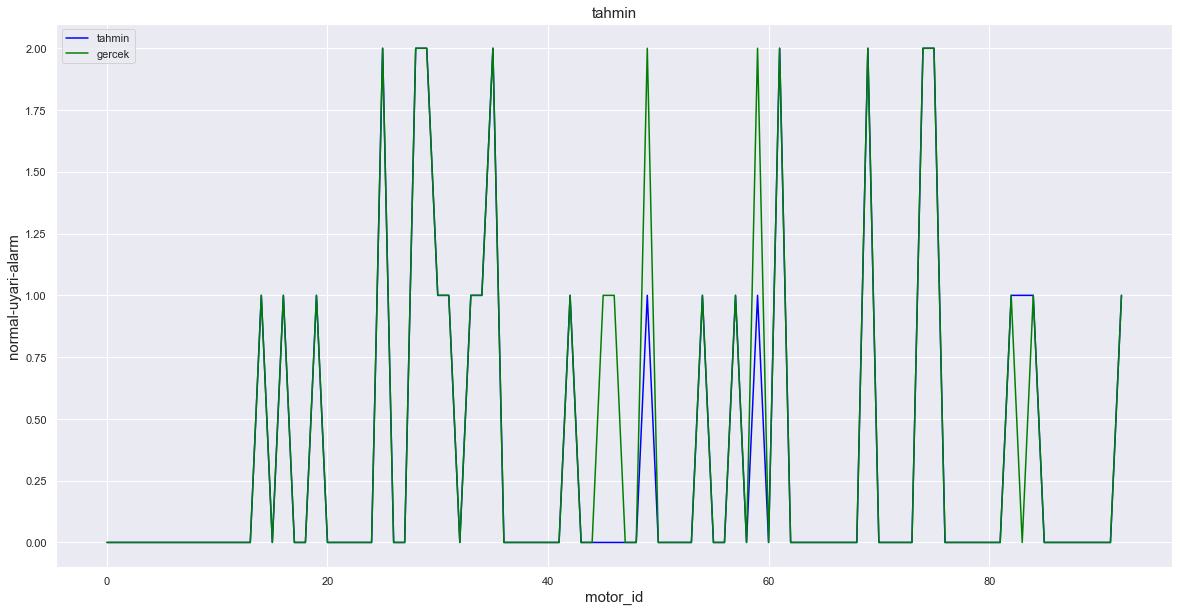

In [149]:
fig_verify = plt.figure(figsize=(20, 10))
plt.plot(y_pred_test, color="blue")
plt.plot(y_true_test, color="green")
plt.title('tahmin', size = 15)
plt.ylabel('normal-uyari-alarm', size = 15)
plt.xlabel('motor_id', size = 15)
plt.legend(['tahmin', 'gercek'], loc='upper left')
plt.show()
#fig_verify.savefig("generated/model_verify.png")

# Feature Selection

In [155]:
train_df.columns

Index(['id', 'cycle', 'settings_1', 'settings_2', 'sensor_2', 'sensor_3',
       'sensor_4', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11',
       'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17',
       'sensor_20', 'sensor_21', 'rul', 'label1', 'label2', 'cycle_norm'],
      dtype='object')

In [156]:
X=train_df.drop(['id', 'cycle','rul', 'label1', 'label2',], axis=1)
y=train_df['label2']

In [157]:
X.shape, y.shape

((20631, 17), (20631,))

In [158]:
impRF = RandomForestClassifier(n_estimators=500, criterion="gini", random_state=123)
impRF.fit(X,y)

imp = {}
for i in range(len(X.columns)):
    imp[X.columns[i]] = [impRF.feature_importances_[i]]
pd.DataFrame.from_dict(imp, orient="index", columns=["Importance"]).sort_values("Importance", ascending=False).head(25).style.background_gradient()

,Importance
sensor_11,0.177897
sensor_4,0.133207
sensor_12,0.109179
sensor_7,0.083734
sensor_15,0.075874
sensor_9,0.063847
sensor_14,0.059101
sensor_21,0.057285
sensor_20,0.050823
sensor_2,0.041617
